In [1]:
import h5py
import pandas as pd
import awkward as ak
import km3io as ki
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sn
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, Flatten
from tensorflow.keras.optimizers import Adam
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import (
    GradientBoostingRegressor,
    RandomForestRegressor,
    ExtraTreesRegressor,
    HistGradientBoostingRegressor,
)
from sklearn.neural_network import MLPRegressor

/Users/meskara/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [3]:
filename = '/Users/meskara/Desktop/Energy_Reconstruction/Data_for_ML.h5'

Data = h5py.File(filename)

In [4]:
y = Data['E'][:]

a = Data['a'][:]

channel_id = Data['channel_id'][:]

dir_x = Data['dir_x'][:]

dir_y = Data['dir_y'][:]

dir_z = Data['dir_z'][:]

dom_id = Data['dom_id'][:]

pos_x = Data['pos_x'][:]

pos_y = Data['pos_y'][:]

pos_z = Data['pos_z'][:]

t = Data['t'][:]

tdc = Data['tdc'][:]

tot = Data['tot'][:]

trig = Data['trig'][:]


In [5]:
X = np.column_stack([a,
channel_id,
dir_x,
dir_y,
dir_z,
dom_id,
pos_x,
pos_y,
pos_z,
t,
tdc,
tot, 
trig])


In [6]:
print(X.shape)

(6676, 13)


In [7]:
y = np.log10(y)

In [8]:
scaler = StandardScaler()

X_scaled = scaler.fit_transform(X)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
y_test_original = 10 ** y_test

["HistGradientBoosting", HistGradientBoostingRegressor(learning_rate=0.1, max_iter=500)],
    ["LightGBM", lgb.LGBMRegressor(random_state=0, n_jobs=-1, learning_rate=0.1, num_iterations=100)],
    ["XGBoost", xgb.XGBRegressor(n_jobs=-1, random_state=0, learning_rate=0.1)],
    ["MLP", MLPRegressor(random_state=0, hidden_layer_sizes=(100, 50, 25), max_iter=100)]
    ["GradientBoosting", GradientBoostingRegressor(random_state=0, learning_rate=0.5, n_estimators=100)],
    ["ExtraTrees", ExtraTreesRegressor(random_state=0, n_jobs=-1, n_estimators=25)],

In [22]:
model = ExtraTreesRegressor(random_state=0, n_jobs=-1, n_estimators=25).fit(X_train, y_train)

In [23]:
y_pred_log = model.predict(X_test)

In [24]:
y_pred = 10 ** y_pred_log

# Calculate performance metrics
mae = mean_absolute_error(y_test_original, y_pred)
mse = mean_squared_error(y_test_original, y_pred)
r2 = r2_score(y_test_original, y_pred)

In [25]:
print(f"Model Performance:")
print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"R2 Score: {r2}")

Model Performance:
MAE: 3848943.699918138
MSE: 170612194995874.9
R2 Score: 0.07569820396940896


In [26]:
BINS = np.logspace(1,9,50)

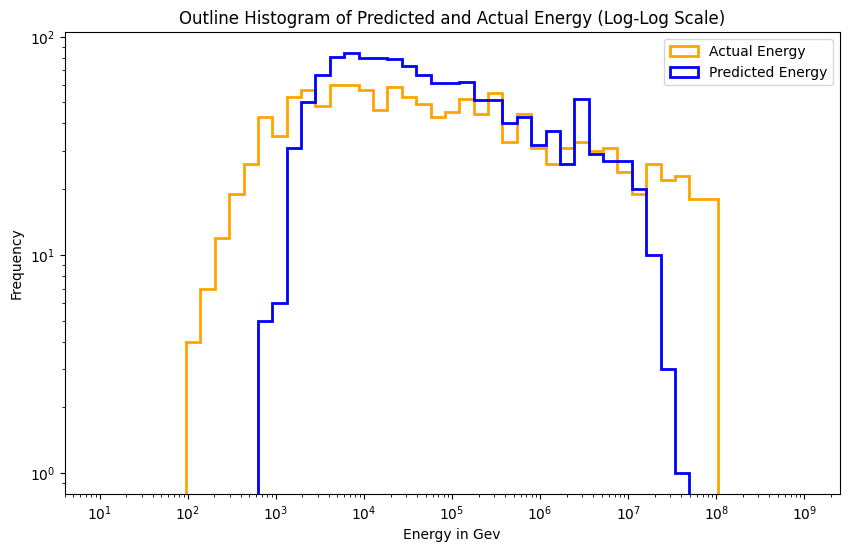

In [27]:
plt.figure(figsize=(10, 6))

plt.hist(y_test_original, bins=BINS, histtype='step', color='orange', linewidth=2, label='Actual Energy')
plt.hist(y_pred, bins=BINS, histtype='step', color='blue', linewidth=2, label='Predicted Energy')

plt.xscale('log')
plt.yscale('log')

plt.xlabel('Energy in Gev')
plt.ylabel('Frequency')
plt.title('Outline Histogram of Predicted and Actual Energy (Log-Log Scale)')

plt.legend()

plt.show()

In [171]:
import seaborn as sns
residuals = y_test_original - y_pred

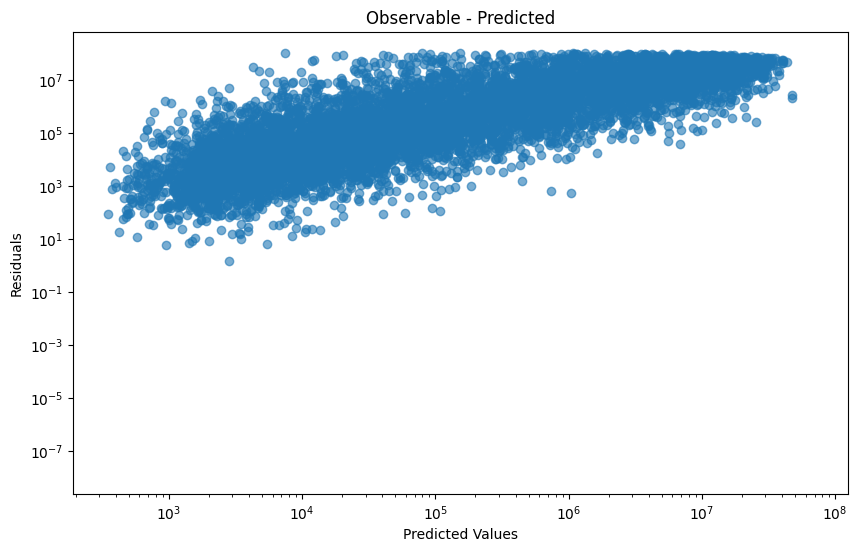

In [172]:
plt.figure(figsize=(10, 6))
#sns.residplot(x=y_pred, y=residuals,scatter_kws={'alpha': 0.5})
plt.scatter(y_pred, residuals, alpha=0.6)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Observable - Predicted')
plt.axhline(y=0, color='r', linestyle='--')
plt.xscale('log')
plt.yscale('log')
plt.show()